# Detecting SSE events in Japan using CNN

In [987]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from FindAreaSSE import display_visualisation, find_use_stations
from scipy import signal

Import known SSE events

In [988]:
knownSSE = pd.read_csv("Nishimura/Nishimura2013.csv")
knownSSE = knownSSE[['date', 'lat', 'lon']]
sortedSSE = knownSSE.sort_values(by="date").drop_duplicates().reset_index(drop=True)

startdate = sortedSSE.iloc[0]['date']
enddate = sortedSSE.iloc[sortedSSE.shape[0]-1]['date']
print("Known SSE start date: ", startdate)
print("Known SSE end date: ", enddate)
print("Numbers of SSE: ", sortedSSE.shape[0])

Known SSE start date:  1996-09-18
Known SSE end date:  2012-01-02
Numbers of SSE:  158


In [989]:
print(sortedSSE.head())

         date     lat        lon
0  1996-09-18  33.722  133.13300
1  1996-11-07  34.950  138.29500
2  1997-01-22  34.920  137.01700
3  1997-03-20  33.674  133.23599
4  1997-04-03  33.883  136.03500


Import station data

In [990]:
# Choose directory
directory_name = "./japanGNSS"
files = os.listdir(directory_name)

# Process data
GNSSdata = []
stationnames = []

# data range to be used
dates = pd.date_range('1996-12-12', '2020-01-01')

stationsprocessed = 0
for filename in files:
    if filename.endswith(".res"):
        if filename.startswith("._"):
            continue
        # read in file
        path = os.path.join(directory_name, filename)
        GNSSdataframe = pd.read_csv(path, delim_whitespace=True, header=None)

        # parse data
        GNSSdataframe.columns = ["date", "NS_displacement", "EW_displacement", "UD_displacement", "Length_change"]
        GNSSdataframe = GNSSdataframe.drop(columns=["Length_change"])
        GNSSdataframe["date"] = pd.to_datetime(GNSSdataframe["date"])
        GNSSdataframe = GNSSdataframe.set_index("date")

        # Remove double up indexes
        GNSSdataframe = GNSSdataframe.loc[~GNSSdataframe.index.duplicated(), :]

        # reindex to desired time period
        idx = pd.DatetimeIndex(dates)
        GNSSdataframe = GNSSdataframe.reindex(idx)

        # if the number of days missing is too large then drop
        missingdays = GNSSdataframe.shape[0] - GNSSdataframe.dropna().shape[0]
        if missingdays < 200:
            p = GNSSdataframe.interpolate()
            nullremaining = p.shape[0] - p.dropna().shape[0]
            if nullremaining == 0:
                stationsprocessed = stationsprocessed+1
                splitted = filename.split(".")
                stationnames.append(splitted[0])
                GNSSdata.append(p)

print("Stations in array: ", stationsprocessed)

Stations in array:  195


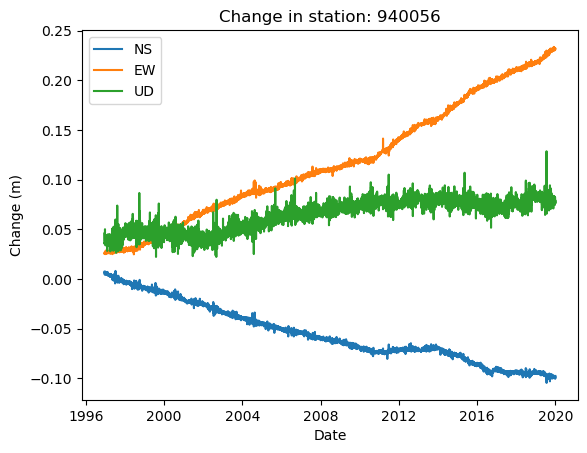

In [991]:
plt.plot(GNSSdata[159])
plt.xlabel("Date")
plt.ylabel("Change (m)")
plt.title("Change in station: " + stationnames[0])
plt.legend(["NS", "EW", "UD"])
plt.show();

Import station coordinates

In [992]:
# find directory
directory_name_cord = "./japanStationLoc"
files_cord = os.listdir(directory_name_cord)

# Grab relevant files for usable stations
revl_files = []
revl_files_paths = []
for filename in files_cord:
    f_split = filename.split(".")

    if f_split[0] in stationnames:
        revl_files.append(f_split[0])
        path = os.path.join(directory_name_cord, filename)
        revl_files_paths.append(path)

    if "0" + f_split[0] in stationnames:
        revl_files.append("0" + f_split[0])
        path = os.path.join(directory_name_cord, filename)
        revl_files_paths.append(path)

print("Relevant files found: ", len(revl_files))
print("Stations coordinates not found: ", list(set(stationnames) - set(revl_files)))


Relevant files found:  195
Stations coordinates not found:  []


In [993]:
# station location is taken from 2019-01-01 and rounded to 4dp
stationarray = np.empty((0,3))
for i in range(0, len(revl_files)):
    opened_file = open(revl_files_paths[i])
    content = opened_file.readlines()
    line = content[20]
    line = line.split()
    lat = round(float(line[7]), 4)
    lon = round(float(line[8]), 4)
    stationarray = np.append(stationarray, np.array([[revl_files[i], lat, lon]]), axis=0)

stations_cord_df = pd.DataFrame(stationarray, columns=["station", "lat", "lon"])
stations_cord_df["lat"] = stations_cord_df["lat"].astype(float)
stations_cord_df["lon"] = stations_cord_df["lon"].astype(float)

print(stations_cord_df.head())
stations_cord_df.to_csv('/Users/haxby/Desktop/Earthquakes/gnss-sse-detection-main/clean_raw_data/stations_cords', index=False)
print(type(stations_cord_df))


  station      lat       lon
0  950291  35.3717  136.5497
1  950391  35.0209  134.2348
2  940062  35.0947  136.1582
3  950283  35.7578  136.9753
4  940070  33.4834  135.7644
<class 'pandas.core.frame.DataFrame'>


Plotting SSE's and Stations

In [994]:
BBox = ((stations_cord_df.lon.min(),   stations_cord_df.lon.max(),
         stations_cord_df.lat.min(), stations_cord_df.lat.max()))
print(BBox)

(130.4768, 138.5157, 32.4454, 36.136)


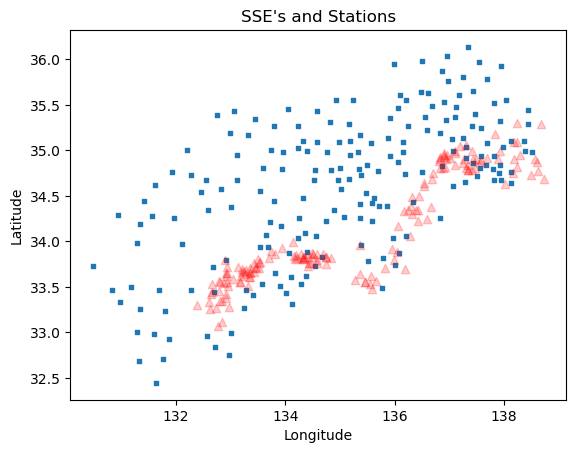

In [995]:
# ruh_m = plt.imread('./japansection.png')
display_visualisation(station_c=stations_cord_df, sortSSE=sortedSSE)
# plt.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal');

We will use 10 stations from Uwajima to train the model since they are relatively close together and appear to have many SSE's in that area

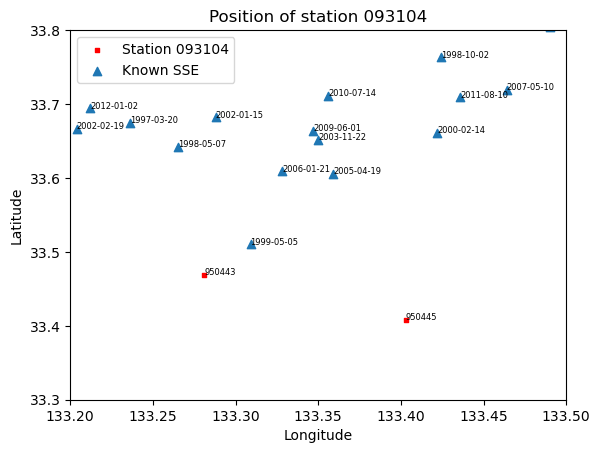

In [996]:
# plt.scatter(stations_cord_df[stations_cord_df.station=='950445'].lon, stations_cord_df[stations_cord_df.station=='950445'].lat, zorder=1, marker='s', s=10, color='r')
plt.scatter(stations_cord_df.lon, stations_cord_df.lat, zorder=1, marker='s', s=10, color='r')
for name in stationnames:
    plt.annotate(name, (stations_cord_df[stations_cord_df.station==name].iloc[0].lon, 
                        stations_cord_df[stations_cord_df.station==name].iloc[0].lat),
                 fontsize=6)
plt.scatter(sortedSSE.lon, sortedSSE.lat, alpha=1, marker='^') #c=sortedSSE.date,

# this is messy but used to find a SSE date close to a station
for i in range(sortedSSE.shape[0]):
    # if (sortedSSE.iloc[i].date > '1999-01-01' and sortedSSE.iloc[i].date < '2001-01-01'): 
        plt.annotate(sortedSSE.loc[i].date, (sortedSSE.loc[i].lon, sortedSSE.loc[i].lat),
                    fontsize=6)

#higher
# longhigh = 138.7
# longlow = 136.1
# lathigh = 36.0
# latlow = 33.6

#lower
# longhigh = 134.75
# longlow = 132.05
# lathigh = 34.94
# latlow = 32.0


#this is the first bounding box used to create orginal 58 days data
# plt.xlim(132.5, 133.7)
# plt.ylim(32.8, 33.94)

#this is the second bounding box used to create the 
plt.xlim(133.2, 133.5)
plt.ylim(33.3, 33.8)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Position of station 093104")
plt.legend(['Station 093104', 'Known SSE'])

#Third Area
# plt.xlim(134, 136)
# plt.ylim(33, 34.5)

In [997]:
# single station
stations_cord_df[stations_cord_df.station=='093104']

,station,lat,lon
74,093104,34.7181,137.5149


- There is a SSE near station 021049 on 2004-12-29
- There is a SSE near station 021048 on 2006-10-05


In [998]:
print(sortedSSE.head())

         date     lat        lon
0  1996-09-18  33.722  133.13300
1  1996-11-07  34.950  138.29500
2  1997-01-22  34.920  137.01700
3  1997-03-20  33.674  133.23599
4  1997-04-03  33.883  136.03500


In [999]:
area3_selected_stations = ['950421', '950440', '950441', '950424', '950420', '950423', '950422', '950416', '950418', '950415'] # Area-3
area1_selected_stations = ['940086', '950434' ,'950433' ,'950436' ,'950437' ,'950448' ,'950449' ,'940085' ,'940084' ,'950443'] # Area-1
area2_selected_stations = ['950304', '950302', '950306', '950301', '950303', '093102', '093103', '093099', '093050', '093104'] # Area-2
s_stations_corddf = []
for name_string in area2_selected_stations:
    s_stations_corddf.append(stations_cord_df[stations_cord_df.station==name_string].iloc[0])

s_stations_corddf = pd.DataFrame(s_stations_corddf)

s_stations_corddf

,station,lat,lon
172,950304,34.8234,136.8676
139,950302,34.9950,137.0598
157,950306,34.6487,137.2778
10,950301,35.0395,137.3132
24,950303,34.9197,137.2999
43,093102,34.8648,137.4340
124,093103,34.8087,137.5543
183,093099,34.9377,137.5755
189,093050,34.8353,137.6723
74,093104,34.7181,137.5149


In [852]:
# area2s_stations_corddf = []
# for name_string in area2_selected_stations:
#     area2s_stations_corddf.append(stations_cord_df[stations_cord_df.station==name_string].iloc[0])

# area2s_stations_corddf = pd.DataFrame(area2s_stations_corddf)
# print(area2s_stations_corddf.shape)

In [853]:
# area3s_stations_corddf = []
# for name_string in area3_selected_stations:
#     area3s_stations_corddf.append(stations_cord_df[stations_cord_df.station==name_string].iloc[0])

# area3s_stations_corddf = pd.DataFrame(area3s_stations_corddf)
# print(area3s_stations_corddf.shape)

In [1000]:
# sanity check
selected_sses = find_use_stations(s_stations_corddf, sortedSSE, rad=0.5)

len(selected_sses)

41

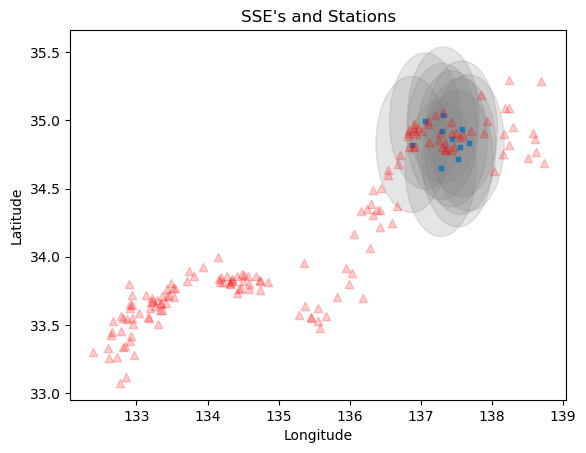

In [1001]:
display_visualisation(s_stations_corddf, sortedSSE, display_circles=True, rad=0.5)

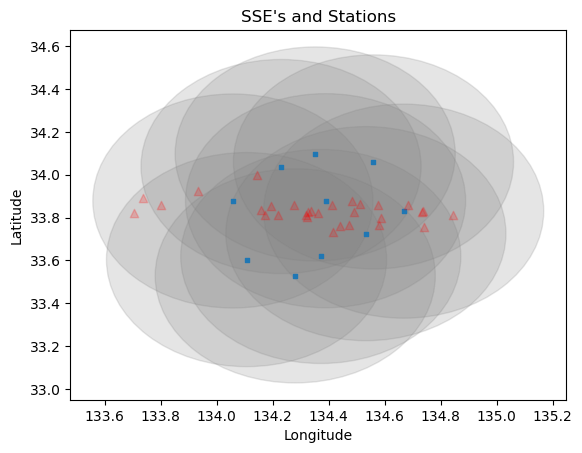

In [902]:
display_visualisation(s_stations_corddf, pd.DataFrame(selected_sses), display_circles=True, rad=0.5)

In [903]:
print(selected_sses)

[date    1997-10-07
lat          33.82
lon        134.362
Name: 7, dtype: object, date    1998-01-05
lat         33.857
lon      134.27699
Name: 10, dtype: object, date    1998-12-30
lat         33.756
lon        134.739
Name: 20, dtype: object, date    1999-11-15
lat         33.859
lon      133.80299
Name: 27, dtype: object, date    2001-03-29
lat         33.767
lon        134.474
Name: 38, dtype: object, date    2001-12-04
lat         33.797
lon        134.586
Name: 42, dtype: object, date    2002-10-17
lat         33.893
lon        133.739
Name: 56, dtype: object, date    2003-02-06
lat         33.731
lon      134.41701
Name: 60, dtype: object, date    2003-04-12
lat          33.82
lon        133.705
Name: 62, dtype: object, date    2003-06-17
lat         33.763
lon        134.578
Name: 64, dtype: object, date    2003-09-13
lat         33.761
lon        134.439
Name: 68, dtype: object, date    2004-04-14
lat         33.813
lon      134.22099
Name: 73, dtype: object, date    2004-08-

In [1002]:
# This to be replaced!
# grab stations between the selected range
s_stations_GNSSdataframe = []
for name in area2_selected_stations:
    s_stations_GNSSdataframe.append(GNSSdata[stationnames.index(name)])
    # if latlow < stations_cord_df.loc[i].lat < lathigh and longlow < stations_cord_df.loc[i].lon < longhigh:
    #     name = stations_cord_df.loc[i].station
    #     selected_stations.append(GNSSdata[stationnames.index(name)])

# # grab SSE between the selected range
# selected_SSE = []
# for i in range(sortedSSE.shape[0]):
#     if latlow < sortedSSE.loc[i].lat < lathigh and longlow < sortedSSE.loc[i].lon < longhigh:
#         p = sortedSSE.loc[i].date
#         selected_SSE.append(p)

# print('stations: ', len(selected_stations))
# print('SSEs: ', len(selected_SSE))
s_stations_GNSSdataframe[0].shape[0]

8421

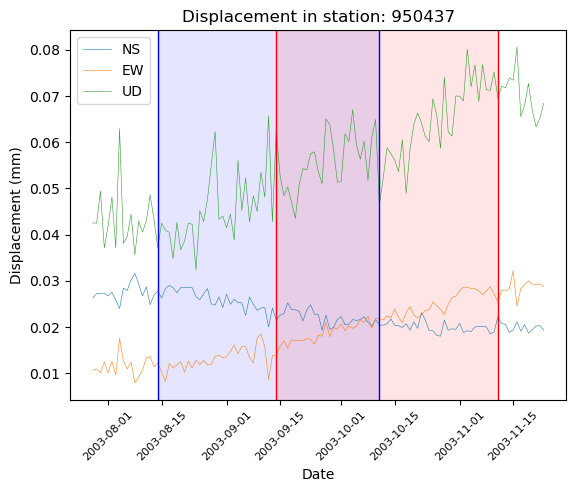

In [926]:
# An SSE appears on 2003-09-25
# stations 950437 and 950449 as very close promixity

station950437 = GNSSdata[stationnames.index('950437')]
plt.plot(station950437.loc['2003-07-28':'2003-11-23'], linewidth=0.4)
# plt.axvline(pd.to_datetime('2003-09-25'), linewidth=2, color='r')
plt.axvline(pd.to_datetime('2003-08-14'), linewidth=1, color='b')
plt.axvline(pd.to_datetime('2003-08-14')+pd.Timedelta(days=58), linewidth=1, color='b')
plt.axvline(pd.to_datetime('2003-9-14'), linewidth=1, color='red')
plt.axvline(pd.to_datetime('2003-9-14')+pd.Timedelta(days=58), linewidth=1, color='red')
# plt.axvline(pd.to_datetime('2003-9-01'), linestyle="--", linewidth=1.5, color='black')
plt.axvspan(
    pd.to_datetime('2003-08-14'),
    pd.to_datetime('2003-08-14')+pd.Timedelta(days=58),
    alpha=0.1,
    color='blue'
)
plt.axvspan(
    pd.to_datetime('2003-9-14'),
    pd.to_datetime('2003-9-14')+pd.Timedelta(days=58),
    alpha=0.1,
    color='red'
)
plt.legend(["NS", "EW", "UD"]);
plt.xticks(fontsize=8, rotation=45)
plt.xlabel("Date")
plt.ylabel("Displacement (mm)")
plt.title("Displacement in station: 950437")
plt.savefig("../figures/displace_with_shaded.jpg")


Selected GNSS stations and SSE

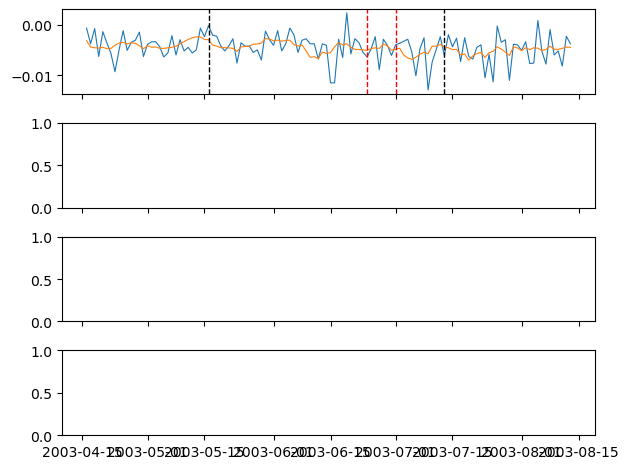

In [1013]:
# An SSE appears on 2003-09-25
# stations 950449 and 950449 as very close promixity

fig, ax = plt.subplots(4, 1, sharex='all')

window_size = 7

station950420 = GNSSdata[stationnames.index('950420')]
# filtered_station = station950420['NS_displacement']
ns_ma = []
i=0

while i < len(station950420) - window_size + window_size:
    # window = arr
    if i < window_size:
        ns_ma.append(station950420.iloc[i]['NS_displacement'])
    else:
        window_ns = station950420[i: i+window_size]['NS_displacement']
        window_ave_ns = sum(window_ns) / window_size
        ns_ma.append(window_ave_ns)

    i+=1

# len(ns_ma)
station950420 = station950420.assign(ns_ma = ns_ma)
ax[0].plot(station950420.loc['2003-04-16':'2003-08-13']['NS_displacement'], linewidth=0.8)
ax[0].plot(station950420.loc['2003-04-16':'2003-08-13']['ns_ma'], linewidth=0.8)
# # plt.axvline(pd.to_datetime('2003-09-25'), linewidth=2, color='r')
ax[0].axvline(pd.to_datetime('2003-06-24'), linestyle='--', linewidth=1, color='red')
ax[0].axvline(pd.to_datetime('2003-07-01'), linestyle='--', linewidth=1, color='red')
fig.tight_layout();

ax[0].axvline(pd.to_datetime('2003-05-16'), linestyle='--', linewidth=1, color='black')
ax[0].axvline(pd.to_datetime('2003-07-13'), linestyle='--', linewidth=1, color='black')
# plt.legend(["NS", "EW", "UD"]);

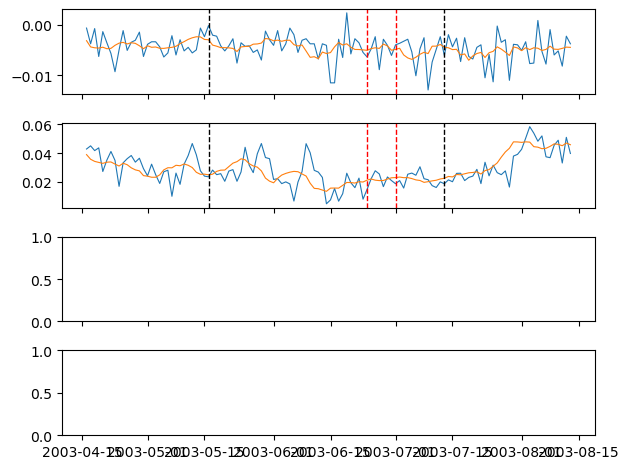

In [1014]:
window_size = 8

station950449 = GNSSdata[stationnames.index('950449')]
# filtered_station = station950449['UD_displacement']
UD_ma = []
i=0

while i < len(station950449) - window_size + window_size:
    # window = arr
    if i < window_size:
        UD_ma.append(station950449.iloc[i]['UD_displacement'])
    else:
        window_UD = station950449[i: i+window_size]['UD_displacement']
        window_ave_UD = sum(window_UD) / window_size
        UD_ma.append(window_ave_UD)

    i+=1

# len(UD_ma)
station950449 = station950449.assign(UD_ma = UD_ma)
ax[1].plot(station950449.loc['2003-04-16':'2003-08-13']['UD_displacement'], linewidth=0.8)
ax[1].plot(station950449.loc['2003-04-16':'2003-08-13']['UD_ma'], linewidth=0.8)
# # plt.axvline(pd.to_datetime('2003-09-25'), linewidth=2, color='r')
ax[1].axvline(pd.to_datetime('2003-06-24'), linestyle='--', linewidth=1, color='red')
ax[1].axvline(pd.to_datetime('2003-07-01'), linestyle='--', linewidth=1, color='red')

ax[1].axvline(pd.to_datetime('2003-05-16'), linestyle='--', linewidth=1, color='black')
ax[1].axvline(pd.to_datetime('2003-07-13'), linestyle='--', linewidth=1, color='black')
# plt.legend(["UD", "EW", "UD"]);
fig

In [1015]:
window_size = 8

station940085 = GNSSdata[stationnames.index('940085')]
# filtered_station = station940085['UD_displacement']
UD_ma = []
i=0

while i < len(station940085) - window_size + window_size:
    # window = arr
    if i < window_size:
        UD_ma.append(station940085.iloc[i]['UD_displacement'])
    else:
        window_UD = station940085[i: i+window_size]['UD_displacement']
        window_ave_UD = sum(window_UD) / window_size
        UD_ma.append(window_ave_UD)

    i+=1

# len(UD_ma)
station940085 = station940085.assign(UD_ma = UD_ma)
ax[2].plot(station940085.loc['2003-04-16':'2003-08-13']['UD_displacement'], linewidth=0.8)
ax[2].plot(station940085.loc['2003-04-16':'2003-08-13']['UD_ma'], linewidth=0.8)
# # plt.axvline(pd.to_datetime('2003-09-25'), linewidth=2, color='r')
ax[2].axvline(pd.to_datetime('2003-06-24'), linestyle='--', linewidth=1, color='red')
ax[2].axvline(pd.to_datetime('2003-07-01'), linestyle='--', linewidth=1, color='red')


ax[2].axvline(pd.to_datetime('2003-05-16'), linestyle='--', linewidth=1, color='black')
ax[2].axvline(pd.to_datetime('2003-07-13'), linestyle='--', linewidth=1, color='black')
# plt.legend(["UD", "EW", "UD"]);

In [1016]:
window_size = 8

station940084 = GNSSdata[stationnames.index('940084')]
# filtered_station = station940084['UD_displacement']
UD_ma = []
i=0

while i < len(station940084) - window_size + window_size:
    # window = arr
    if i < window_size:
        UD_ma.append(station940084.iloc[i]['UD_displacement'])
    else:
        window_UD = station940084[i: i+window_size]['UD_displacement']
        window_ave_UD = sum(window_UD) / window_size
        UD_ma.append(window_ave_UD)

    i+=1

# len(UD_ma)
station940084 = station940084.assign(UD_ma = UD_ma)
ax[3].plot(station940084.loc['2003-04-16':'2003-08-13']['UD_displacement'], linewidth=0.8)
ax[3].plot(station940084.loc['2003-04-16':'2003-08-13']['UD_ma'], linewidth=0.8)
# # plt.axvline(pd.to_datetime('2003-09-25'), linewidth=2, color='r')
ax[3].axvline(pd.to_datetime('2003-06-24'), linestyle='--', linewidth=1, color='red')
ax[3].axvline(pd.to_datetime('2003-07-01'), linestyle='--', linewidth=1, color='red')


ax[3].axvline(pd.to_datetime('2003-05-16'), linestyle='--', linewidth=1, color='black')
ax[3].axvline(pd.to_datetime('2003-07-13'), linestyle='--', linewidth=1, color='black')
ax[3].tick_params(labelrotation=-15)
# plt.legend(["UD", "EW", "UD"]);

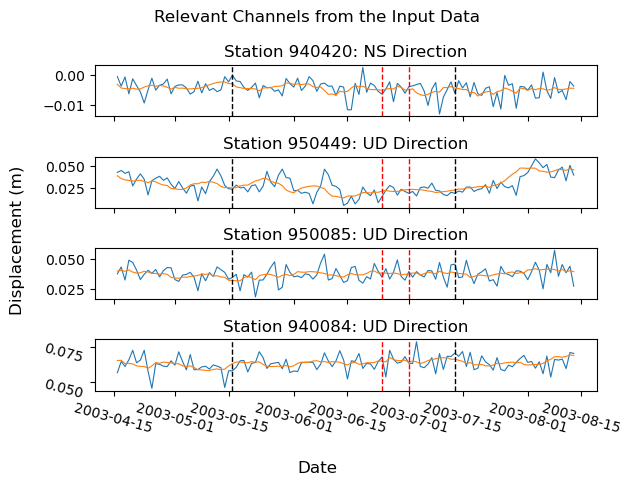

In [1022]:
ax[0].set_title("Station 940420: NS Direction")
ax[1].set_title("Station 950449: UD Direction")
ax[2].set_title("Station 950085: UD Direction")
ax[3].set_title("Station 940084: UD Direction")
fig.suptitle("Relevant Channels from the Input Data")
fig.supxlabel("Date")
fig.supylabel("Displacement (m)")
fig.tight_layout()
fig
# fig.savefig("relevant-gnss-channels.pdf")

In [1003]:
direct_name = 'area2-detrended'
linear_trend_remove = True
standardise_data = False

size = 58
directory_path_non = "../58daysdata/" + direct_name + "/nonSSE/"
directory_path_SSE = "../58daysdata/" + direct_name + "/SSE/"
directory_path_after = "../58daysdata/" + direct_name + "/after/"


if not os.path.isdir(directory_path_non):
    os.makedirs(directory_path_non)

if not os.path.isdir(directory_path_SSE): 
    os.makedirs(directory_path_SSE)

if not os.path.isdir(directory_path_after): 
    os.makedirs(directory_path_after)

sse_c = 0
non_c = 0
a_2012 = 0

data = []

if linear_trend_remove:
    for station_single in s_stations_GNSSdataframe:
        detrended = signal.detrend(station_single, axis=0)
        to_np = np.vstack(detrended)
        station_single.iloc[:,[0]] = to_np[:, [0]]
        station_single.iloc[:,[1]] = to_np[:, [1]]
        station_single.iloc[:,[2]] = to_np[:, [2]]

if standardise_data:
    for station_single in s_stations_GNSSdataframe:
        station_single.iloc[:,[0]] = (station_single.iloc[:,[0]]-station_single.iloc[:,[0]].mean()) / station_single.iloc[:,[0]].std()
        station_single.iloc[:,[1]] = (station_single.iloc[:,[1]]-station_single.iloc[:,[1]].mean()) / station_single.iloc[:,[1]].std()
        station_single.iloc[:,[2]] = (station_single.iloc[:,[2]]-station_single.iloc[:,[2]].mean()) / station_single.iloc[:,[2]].std()

for i in range(s_stations_GNSSdataframe[0].shape[0]):

    if s_stations_GNSSdataframe[0][i:i+size].shape[0] < size:
        break;
    start = s_stations_GNSSdataframe[0].index[i].date()
    end = s_stations_GNSSdataframe[0].index[i+size-1].date()

    single_data = np.empty([0,size])
    for q in range(len(s_stations_GNSSdataframe)):
        to_nump = s_stations_GNSSdataframe[q][i:i+size].transpose().to_numpy()
        single_data = np.append(single_data, to_nump, axis=0)
    f_name = str(start) + ":" + str(end)

    sse = False
    for s_sse in selected_sses:
        # print(s_sse['date'])
        if start <= pd.to_datetime(s_sse['date']).date() <= end:
            sse = True
            break;
    
    # if linear_trend_remove:
    #     transformed = signal.detrend(single_data)
    #     standard_deviations = np.std(transformed, axis = 1)
    #     transformed_standardised = transformed/standard_deviations[:,None]
    #     single_data = transformed_standardised
    # data.append(single_data)
    
    if end > pd.to_datetime('2012-01-01').date():
        a_2012 = a_2012 + 1
        np.savetxt(directory_path_after + f_name + ".csv", single_data, delimiter=",")
    
    elif sse:
        sse_c = sse_c + 1
        np.savetxt(directory_path_SSE + f_name + ".csv", single_data, delimiter=",")

    else:
        non_c = non_c + 1
        np.savetxt(directory_path_non + f_name + ".csv", single_data, delimiter=",")

print("Numbers of SSE data points: ", sse_c)
print("Number of non SSE data points: ", non_c)
print("Number of data points after 2012: ", a_2012)

Numbers of SSE data points:  2136
Number of non SSE data points:  3306
Number of data points after 2012:  2922


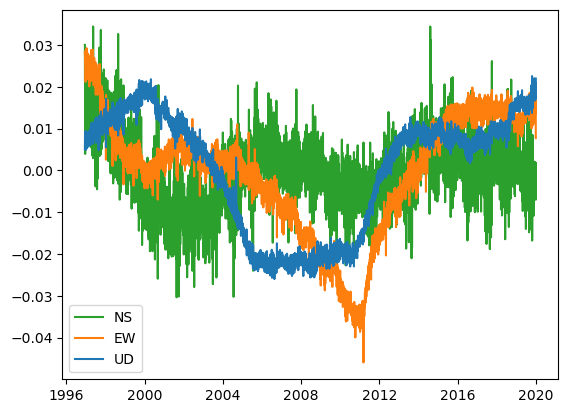

In [1004]:
fig, ax = plt.subplots(3,1, sharex='all')

ax[0].set_title("Raw Data")
ax[0].plot(s_stations_GNSSdataframe[9].iloc[:,2], '#2ca02c')
plt.plot(s_stations_GNSSdataframe[9].iloc[:,1], '#ff7f0e')
plt.plot(s_stations_GNSSdataframe[9].iloc[:,0], '#1f77b4')
plt.legend(["NS", "EW", "UD"])

linear_trend_remove = True
standardise_data = True

# ax[2].set_title("Standardised")
# ax[2].plot((s_stations_GNSSdataframe[0].iloc[:,[2]]-s_stations_GNSSdataframe[0].iloc[:,[2]].mean()) / s_stations_GNSSdataframe[0].iloc[:,[2]].std(), '#2ca02c')
# ax[2].plot((s_stations_GNSSdataframe[0].iloc[:,[1]]-s_stations_GNSSdataframe[0].iloc[:,[1]].mean()) / s_stations_GNSSdataframe[0].iloc[:,[1]].std(), '#ff7f0e')
# ax[2].plot((s_stations_GNSSdataframe[0].iloc[:,[0]]-s_stations_GNSSdataframe[0].iloc[:,[0]].mean()) / s_stations_GNSSdataframe[0].iloc[:,[0]].std(), '#1f77b4')

# if linear_trend_remove:
#     for station_single in s_stations_GNSSdataframe:
#         detrended = signal.detrend(station_single, axis=0)
#         to_np = np.vstack(detrended)
#         station_single.iloc[:,[0]] = to_np[:, [0]]
#         station_single.iloc[:,[1]] = to_np[:, [1]]
#         station_single.iloc[:,[2]] = to_np[:, [2]]

# ax[1].set_title("Detrended")
# ax[1].plot(s_stations_GNSSdataframe[0].iloc[:,2], '#2ca02c')
# ax[1].plot(s_stations_GNSSdataframe[0].iloc[:,1], '#ff7f0e')
# ax[1].plot(s_stations_GNSSdataframe[0].iloc[:,0], '#1f77b4')
# ax[1].set_ylim([-0.2, 0.2])

# if standardise_data:
#     for station_single in s_stations_GNSSdataframe:
#         station_single.iloc[:,[0]] = (station_single.iloc[:,[0]]-station_single.iloc[:,[0]].mean()) / station_single.iloc[:,[0]].std()
#         station_single.iloc[:,[1]] = (station_single.iloc[:,[1]]-station_single.iloc[:,[1]].mean()) / station_single.iloc[:,[1]].std()
#         station_single.iloc[:,[2]] = (station_single.iloc[:,[2]]-station_single.iloc[:,[2]].mean()) / station_single.iloc[:,[2]].std()

# ax[3].set_title("Detrended and Standardised")
# ax[3].plot(s_stations_GNSSdataframe[0].iloc[:,2], '#2ca02c')
# ax[3].plot(s_stations_GNSSdataframe[0].iloc[:,1], '#ff7f0e')
# ax[3].plot(s_stations_GNSSdataframe[0].iloc[:,0], '#1f77b4')
# fig.tight_layout()


In [863]:
fig.savefig("detrended.pdf")

# This bit looks at potential SSE

NS_displacement    float64
EW_displacement    float64
UD_displacement    float64
ns_ma              float64
ew_ma              float64
ud_ma              float64
dtype: object


Text(0, 0.5, 'Displacement (mm)')

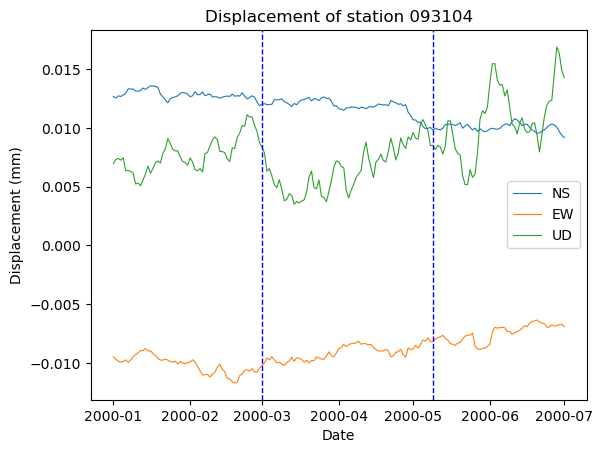

In [864]:
# An SSE appears on 2003-09-25
# stations 950437 and 950449 as very close promixity
station950421 = GNSSdata[stationnames.index('093104')]
# station950421.to_csv("station950421.csv")
ns_ma = []
ew_ma = []
ud_ma = []

window_size = 7
i = 0

while i < len(station950421) - window_size + window_size:
    # window = arr
    if i < window_size:
        ns_ma.append(station950421.iloc[i]['NS_displacement'])
        ew_ma.append(station950421.iloc[i]['EW_displacement'])
        ud_ma.append(station950421.iloc[i]['UD_displacement'])
    else:
        window_ns = station950421[i: i+window_size]['NS_displacement']
        window_ave_ns = sum(window_ns) / window_size
        ns_ma.append(window_ave_ns)

        window_ew = station950421[i: i+window_size]['EW_displacement']
        window_ave_ew = sum(window_ew) / window_size
        ew_ma.append(window_ave_ew)

        window_ud = station950421[i: i+window_size]['UD_displacement']
        window_ave_ud = sum(window_ud) / window_size
        ud_ma.append(window_ave_ud)

    i+=1

station950421 = station950421.assign(ns_ma = ns_ma)
station950421 = station950421.assign(ew_ma = ew_ma)
station950421 = station950421.assign(ud_ma = ud_ma)
# station950421.to_csv("station950421.csv")
print(station950421.dtypes)
# station950421.iloc[0]

plt.plot(station950421.loc['2000-01-01':'2000-07-1'][['ns_ma', 'ew_ma', 'ud_ma']], linewidth=0.8)
# plt.axvline(pd.to_datetime('2003-09-25'), linewidth=2, color='r')
plt.axvline(pd.to_datetime('2000-03-01'), linestyle='--', linewidth=1, color='b')
plt.axvline(pd.to_datetime('2000-05-09'), linestyle='--', linewidth=1, color='b')
plt.legend(["NS", "EW", "UD"]);
plt.title("Displacement of station 093104")
plt.xlabel("Date")
plt.ylabel("Displacement (mm)")

IndexError: list index out of range

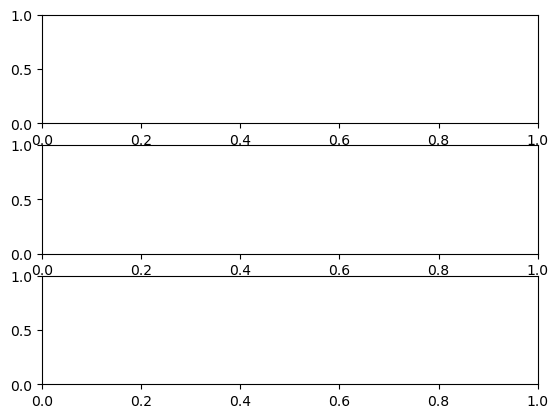

In [865]:
fig, ax = plt.subplots(3)

single_point = data[1670]
# single_point.shape
# plt.plot(single_point[0])
# plt.plot(single_point[1])
# plt.plot(single_point[2])
transformed = signal.detrend(single_point)
standard_deviations = np.std(transformed, axis = 1)
transformed_standardised = transformed/standard_deviations[:,None]

ax[0].plot(single_point[0])
ax[0].plot(single_point[1])
ax[0].plot(single_point[2])
ax[0].set_title("Raw Data")
ax[0].legend(['NS', "EW", "UD"])

ax[1].plot(transformed[0])
ax[1].plot(transformed[1])
ax[1].plot(transformed[2])
ax[1].set_title("Detrended")

ax[2].plot(transformed_standardised[0])
ax[2].plot(transformed_standardised[1])
ax[2].plot(transformed_standardised[2])
ax[2].set_title("Detrended and Standardised")

fig.tight_layout()
fig.savefig("detrended.pdf")

# print(train))
# print(np.std(transformed))
# transformed.shape
# print(single_point.shape)
